                                       EN2550 - Fundamentals of Image Processing and Machine Vision
                                                         Assignment 2

Index Number : 190280N                    
Name : Jegakumaran P.                
Github Link : 

In [5]:
#Question 1
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
from skimage.measure import CircleModel, ransac
import cv2 as cv
# np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s*np.random.randn(half_n)
x , y = (r+n)*np.cos(t),(r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
m, b = -1,2
x = np.linspace(-12,12,half_n)
y = m*x+b+s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
X = np.vstack((X_circ,X_line))

In [6]:
# RANSAC Function
class RANSAC:
	def __init__(self, x_data, y_data, n):
		self.x_data = x_data
		self.y_data = y_data
		self.n = n # n: how many times try sampling
		self.d_min = 99999
		self.best_model = None
	def random_sampling(self):
		sample = []
		save_ran = []
		count = 0
		# get three points from data
		while True:
			ran = np.random.randint(len(self.x_data))
			if ran not in save_ran:
				sample.append((self.x_data[ran], self.y_data[ran]))
				save_ran.append(ran)
				count += 1
				if count == 3:
					break
		return sample

	def make_model(self, sample): # calculate A, B, C value from three points by using matrix
		pt1 = sample[0]
		pt2 = sample[1]
		pt3 = sample[2]
		A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
		B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
		inv_A = np.linalg.inv(A) 
		c_x, c_y = np.dot(inv_A, B) / 2
		c_x, c_y = c_x[0], c_y[0]
		r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)
		return c_x, c_y, r

	def eval_model(self, model):
		d = 0
		c_x, c_y, r = model
		for i in range(len(self.x_data)):
			dis = np.sqrt((self.x_data[i]-c_x)**2 + (self.y_data[i]-c_y)**2)
			if dis >= r:
				d += dis - r
			else:
				d += r - dis
		return d

	def execute_ransac(self):
		for i in range(self.n):
			sample=self.random_sampling()
			model = self.make_model(sample)
			d_temp = self.eval_model(model)
			if self.d_min > d_temp:
				self.best_model = model
				self.d_min = d_temp
				best_sample=sample
		return best_sample

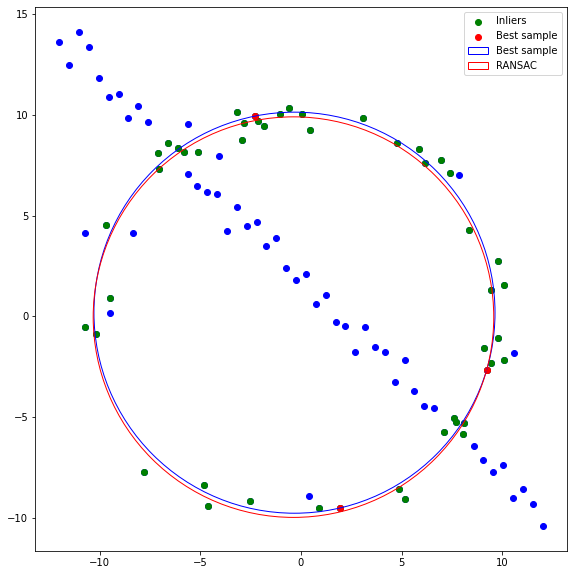

In [7]:
size=len(X[:,0])
ransac = RANSAC(X[:,0],X[:,1], 80)
sample = ransac.execute_ransac()# execute ransac algorithm
a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2] # get best model from ransac
threshold=0.8
inliers=[]
for i in range(size):
	if np.sqrt((X[i,0]-a)**2+(X[i,1]-b)**2)<r+threshold and np.sqrt((X[i,0]-a)**2+(X[i,1]-b)**2)>r-threshold:
		inliers.append(np.array(X[i]))
inliers=np.array(inliers)
# show result
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1],c='blue', marker='o')
plt.scatter(inliers[:,0],inliers[:,1],c='g',marker='o',label='Inliers')

ransac = RANSAC(inliers[:,0],inliers[:,1], 80)
sample2 = ransac.execute_ransac()
for i in range(len(sample2)):
	sample2[i]=np.array(sample2[i])
sample2=np.array(sample2)
plt.scatter(sample2[:,0],sample2[:,1],c='r',marker='o',label='Best sample')
# get best model from ransac
a_best, b_best, r_best = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]
circle = plt.Circle((a_best, b_best), radius=r_best, color='b', fc='y', fill=False,label='Best sample')
plt.gca().add_patch(circle)

circle = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False,label='RANSAC')
plt.gca().add_patch(circle)
plt.axis('scaled')
plt.legend()
plt.show()

In [8]:
# Question 2
count=1
def click_event(event, x, y, flags, params):
    global count
    if event == cv.EVENT_LBUTTONDOWN:
        print('Point ',count,'= [',x, ',', y,']')
        count+=1
        cv.imshow('image', background)
    if event==cv.EVENT_RBUTTONDOWN:
        print('Point ',count,'= [',x, ',', y,']')
        count+=1
        cv.imshow('image', background)
background = cv.imread(r"Images/images/001.jpg",cv.IMREAD_ANYCOLOR)
print('Four points in the architectural image')
cv.imshow('image', background)
cv.setMouseCallback('image', click_event)
cv.waitKey(0)
cv.destroyAllWindows()

Four points in the architectural image
Point  1 = [ 151 , 208 ]
Point  2 = [ 519 , 292 ]
Point  3 = [ 135 , 516 ]
Point  4 = [ 516 , 515 ]


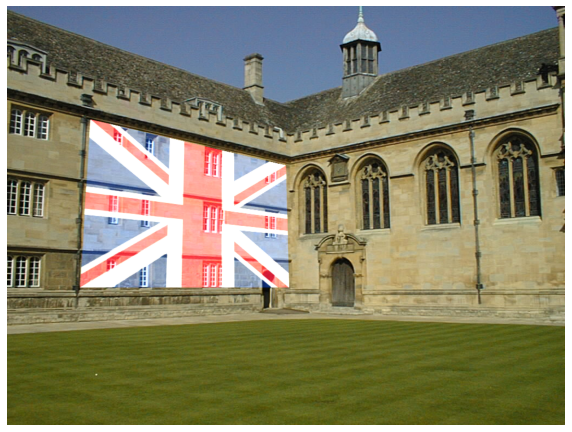

In [9]:
def getImageCorners(image):
    corners = np.zeros((4, 1, 2), dtype=np.float32)
    (width, length, values) = image.shape
    corners[0] = (0, 0)
    corners[1] = (0, width)
    corners[2] = (length, 0)
    corners[3] = (length, width)
    return corners
rows,cols,ch = background.shape
img = cv.imread(r"Images/Flag_of_the_United_Kingdom.svg.png",cv.IMREAD_ANYCOLOR)
pts1=np.float32(getImageCorners(img))
pts2 = np.float32([[154 , 208],[512 , 292],[135 , 516],[518 , 516]]) # Change the coordinates here
M = cv.getPerspectiveTransform(pts1,pts2)    
dst = cv.warpPerspective(img,M,(cols,rows))
overlay = cv.add(background, dst)
plt.figure(figsize=(10,10))
plt.imshow(cv.cvtColor(overlay,cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

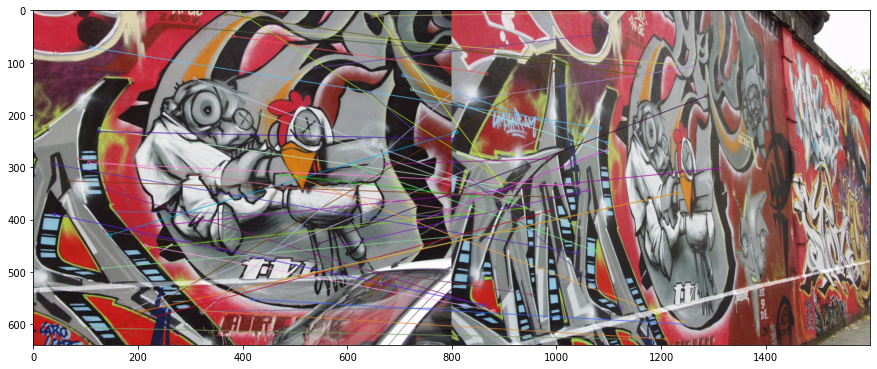

[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


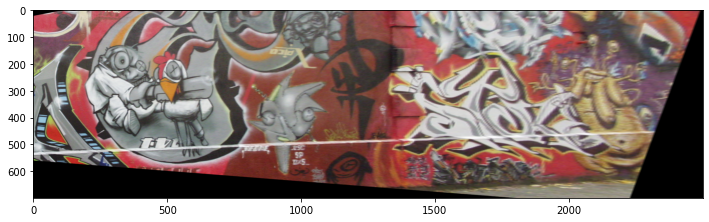

(<matplotlib.image.AxesImage at 0x1f65768e620>, None)

In [2]:
# Question 3
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread(r"Images/graf/img1.ppm",cv.IMREAD_ANYCOLOR)
img5 = cv.imread(r"Images/graf/img5.ppm",cv.IMREAD_ANYCOLOR)
sift = cv.SIFT_create() #sift
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_5, descriptors_5 = sift.detectAndCompute(img5,None)

#feature matching
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_5)
matches = sorted(matches, key = lambda x:x.distance)

img = cv.drawMatches(img1, keypoints_1, img5, keypoints_5, matches[:50], img5, flags=2)
plt.figure(figsize=(15,15))
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB)),plt.show()


# Homography given in the dataset
H=[]
with open(r"Images/graf/H1to5p") as f:
    H=np.array([[float(h) for h in line.split()] for line in f])
print(H)


# Compute Homography using RANSAC









# Stitch img1 onto img5
im1to5=cv.warpPerspective(img5,np.linalg.inv(H),(2500,700))
plt.figure(figsize=(12,12))
plt.imshow(cv.cvtColor(im1to5,cv.COLOR_BGR2RGB)),plt.show()


[[-3.23108707e-01 -2.85732797e+00  3.77353418e+02]
 [-3.33565684e-01 -4.82169028e+00  5.08855022e+02]
 [-7.62678679e-04 -1.00593131e-02  1.00000000e+00]]


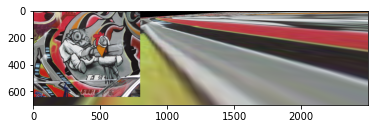

(<matplotlib.image.AxesImage at 0x1f65cc8d990>, None)

In [46]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv.perspectiveTransform(temp_points, H) 

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
  print(H_translation.dot(H))
  output_img = cv.warpPerspective(img2, np.linalg.inv(H_translation.dot(H)), (2500,700))#(x_max-x_min, y_max-y_min)
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img
img_1 = cv.imread(r'Images/graf/img1.ppm')  
img_2 = cv.imread(r'Images/graf/img5.ppm') 
img1 = cv.cvtColor(img_1,cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img_2,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
good = []
for m in matches:
    if (m[0].distance < 0.6*m[1].distance):
        good.append(m)
matches = np.asarray(good)
if (len(matches[:,0]) >= 4):
    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv.findHomography(src, dst, cv.RANSAC, 5.0)
else:
    raise AssertionError('Can’t find enough keypoints.')
output=warpImages(img_1, img_2,H)
plt.figure()
plt.imshow(cv.cvtColor(output,cv.COLOR_BGR2RGB)),plt.show()
